---
format:
  html:
    code-fold: false
---


## Using `PETSc` : Matrix-free solvers

Until now, we have been using our-own implemented solvers to solve the linear or non-linear systems of equations. This is a good way to understand the underlying mechanics of the solvers. However, sometimes it is more convenient to use state-of-the-art solvers that are already implemented, highly optimized and well tested and benchmarked. Such state-of-the-art library now only have basic solvers but also have a lot of advanced solvers for a wide range of problems in science and engineering. Therefore, it is always a good idea to not reinvent the wheel again and again.

`PETSc` is one such state-of-the-art library for solving partial differential equations. It is a collection of solvers for a wide range of problems in science and engineering. It is a very powerful library and is used in a wide range of applications.


In [1]:
import jax

jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
jax.config.update("jax_platforms", "cpu")

import femsolver
from femsolver.utils import auto_vmap
from femsolver import Mesh, Operator, element
from femsolver.plotting import STYLE_PATH, colors

import jax.numpy as jnp
from jax import Array
import equinox as eqx

from petsc4py import PETSc

from typing import Callable, Optional, Tuple
import sparsejac

import numpy as np

import matplotlib.pyplot as plt
import cmcrameri.cm as cmc

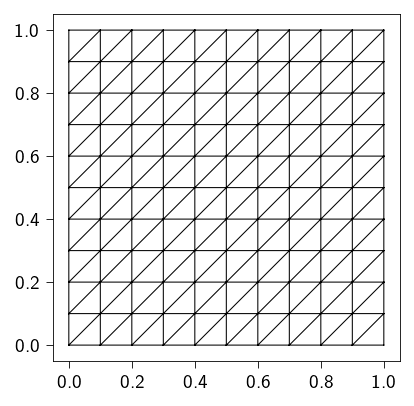

In [2]:
mesh = Mesh.unit_square(10, 10)

n_nodes = mesh.coords.shape[0]
n_dofs_per_node = 2
n_dofs = n_dofs_per_node * n_nodes

plt.style.use(STYLE_PATH)
plt.figure(figsize=(3, 3))
plt.triplot(*mesh.coords.T, mesh.elements, color="k", lw=0.5)
plt.gca().set_aspect("equal")
plt.show()

## Defining the constitutive model


In [3]:
from typing import NamedTuple


class Material(NamedTuple):
    """Material properties for the elasticity operator."""

    mu: float  # Shear modulus
    lmbda: float  # First Lamé parameter


mat = Material(mu=0.5, lmbda=1.0)

In [4]:
@auto_vmap(grad_u=2)
def compute_strain(grad_u: Array) -> Array:
    """Compute the strain tensor from the gradient of the displacement."""
    return 0.5 * (grad_u + grad_u.T)


@auto_vmap(eps=2, mu=0, lmbda=0)
def compute_stress(eps: Array, mu: float, lmbda: float) -> Array:
    """Compute the stress tensor from the strain tensor."""
    I = jnp.eye(2)
    return 2 * mu * eps + lmbda * jnp.trace(eps) * I


@auto_vmap(grad_u=2, mu=0, lmbda=0)
def strain_energy(grad_u: Array, mu: float, lmbda: float) -> Array:
    """Compute the strain energy density."""
    eps = compute_strain(grad_u)
    sig = compute_stress(eps, mu, lmbda)
    return 0.5 * jnp.sum(eps * sig)

## Defining `Operator` and energy functional

In [5]:
tri = element.Tri3()
op = Operator(mesh, tri)


@op.integrate
def total_strain_energy(u: Array, u_grad: Array, *_) -> Array:
    """Compute the total energy of the system."""
    return strain_energy(u_grad, mat.mu, mat.lmbda)

In [6]:
@jax.jit
def total_energy(u_flat):
    u = u_flat.reshape(-1, n_dofs_per_node)
    return total_strain_energy(u)

## Defining the boundary conditions

The boundary conditions are the same as before. We will apply a displacement of `0.3` to the right boundary. The left boundary is fixed both in the x and y directions.


In [7]:
# --- Apply Dirichlet BCs ---
left_nodes = jnp.where(jnp.isclose(mesh.coords[:, 0], 0.0))[0]
right_nodes = jnp.where(jnp.isclose(mesh.coords[:, 0], 1.0))[0]
fixed_dofs = jnp.concatenate(
    [
        2 * left_nodes,
        2 * left_nodes + 1,
        2 * right_nodes,
    ]
)
prescribed_values = jnp.zeros(n_dofs).at[2 * right_nodes].set(0.3)
free_dofs = jnp.setdiff1d(jnp.arange(n_dofs), fixed_dofs)

## Defining `PETSc` solvers

Until here, the framework has been the same as before for solving the problem. Now, we will use the `PETSc` solvers to solve the linear problem. We will use the `SNES` class to solve the non-linear systems of equations.  `SNES` includes several Newton-like nonlinear solvers based on line search techniques and trust region methods.

The `SNES` object is used to solve non-linear systems of the form $F(x) = 0$.

So, we use `jax` to define the gradient of the total energy function.

In [ ]:
gradient = jax.jacrev(total_energy)

In [8]:
u = np.zeros(n_dofs)
u_lower_bounds = np.full(n_dofs, -jnp.inf)
u_upper_bounds = np.full(n_dofs, jnp.inf)

u_lower_bounds[fixed_dofs] = 0.0
u_lower_bounds[2 * right_nodes] = 0.3

u_upper_bounds[fixed_dofs] = 0.0
u_upper_bounds[2 * right_nodes] = 0.3

In [ ]:

class JAXMatMult:
    def __init__(self, gradient: Callable):
        self.x_cur = None
        self.gradient = gradient

    def set_x(self, x: Array):
        """Set the current iterate for the Jacobian-vector product."""
        self.x_cur = x

    def mult(self, A, X, F):
        """Set dF = J(x) * dx"""
        dx = X.getArray(readonly=True)
        tangent = jax.jvp(self.gradient, (self.x_cur,), (dx,))[1]
        F[:] = tangent


class ElasticityProblem:
    def __init__(self, func):
        self.gradient = func
        self.ctx = JAXMatMult(func)

    def set_sol(self, sol):
        self.sol_cur = sol

    def function(self, snes, X, F):
        print(X.getArray(readonly=True))
        x = jnp.array(X.getArray(readonly=True))
        f = self.gradient(x)
        F[:] = f

    def jacobian(self, snes, X, J, P):
        self.ctx.set_x(X.getArray(readonly=True))
        return True

In [10]:
problem = ElasticityProblem(gradient)

In [31]:
snes = PETSc.SNES().create(comm=PETSc.COMM_SELF)
f = PETSc.Vec().createSeq(n_dofs)
J = PETSc.Mat().createPython(
    [n_dofs, n_dofs], comm=PETSc.COMM_SELF, context=problem.ctx
)
J.setUp()


alpha_lb = f.duplicate()
alpha_ub = f.duplicate()
alpha_lb.setArray(u_lower_bounds.reshape(-1))
alpha_ub.setArray(u_upper_bounds.reshape(-1))

snes.setFunction(problem.function, f)
snes.setJacobian(problem.jacobian, J, J)
snes.setType("vinewtonrsls")
snes.setVariableBounds(alpha_lb, alpha_ub)
snes.setTolerances(atol=1e-8, rtol=1e-8, max_it=20)
snes.setConvergenceHistory()
snes.setConvergedReason(reason=PETSc.SNES.ConvergedReason.CONVERGED_FNORM_ABS)

convergence_history = []
snes.setMonitor(lambda _snes, its, norm: convergence_history.append(norm))

# using matrix-free method to solve the linear system
ksp =snes.getKSP()
ksp.setType("cg")
ksp.setTolerances(rtol=1e-10, atol=1e-10)
ksp.setConvergedReason(reason=PETSc.KSP.ConvergedReason.CONVERGED_ATOL)
b, alpha = None, f.duplicate()


alpha.setArray(u.reshape(-1))  # zero inital guess
snes.solve(b, alpha)
print(snes.getConvergedReason())

u_solution = alpha.getArray().reshape((n_nodes, n_dofs_per_node))
_ = snes.destroy()

[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.3 0.  0.3 0.  0.3 0.  0.3 0.  0.3 0.  0.3 0.  0.3 0.
 0.3 0.  0.3 0.  0.3 0.  0.3 0. ]
[ 0.00000000e+00  0.00000000e+

## Post-processing

Since we are using an external library therefore, we need to make sure that it does reach the convergence criteria that we have set. The convergence criteria that we set earlier is that the norm of the residual should be less than `1e-8`.

Below, we plot the convergence history of the `SNES` solver.

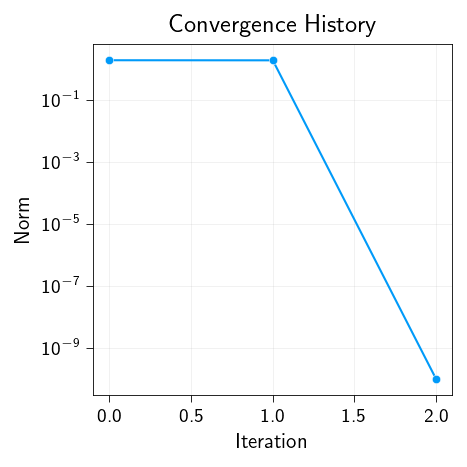

In [32]:
plt.style.use(STYLE_PATH)
plt.figure(figsize=(3, 3), constrained_layout=True)
plt.semilogy(convergence_history, marker="o")
plt.xlabel("Iteration")
plt.ylabel("Norm")
plt.title("Convergence History")
plt.grid(True)
plt.show()

It looks like the solver did reach the expected convergence criteria. Now, we will plot the displacement and stress fields.

In [33]:
@auto_vmap(stress=2)
def von_mises_stress(stress):
    s_xx, s_yy = stress[0, 0], stress[1, 1]
    s_xy = stress[0, 1]
    return jnp.sqrt(s_xx**2 - s_xx * s_yy + s_yy**2 + 3 * s_xy**2)


# squeeze to remove the quad point dimension (only 1 quad point)
grad_u = op.grad(u_solution).squeeze()
strains = compute_strain(grad_u)
stresses = compute_stress(strains, mat.mu, mat.lmbda)
stress_vm = von_mises_stress(stresses)

In [34]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_displacement_and_stress(u, mesh, stress, scale=1.0):
    displaced = mesh.coords + scale * u
    tri_elements = mesh.elements

    plt.style.use(STYLE_PATH)
    fig = plt.figure(figsize=(5, 4))
    ax = plt.axes()
    cb = ax.tripcolor(
        displaced[:, 0],
        displaced[:, 1],
        tri_elements,
        facecolors=stress,
        shading="flat",
        cmap=cmc.managua_r,
        edgecolors="black",
    )
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect("equal")
    ax.set_title("Von Mises Stress on Deformed Mesh")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(cb, cax=cax)
    plt.show()

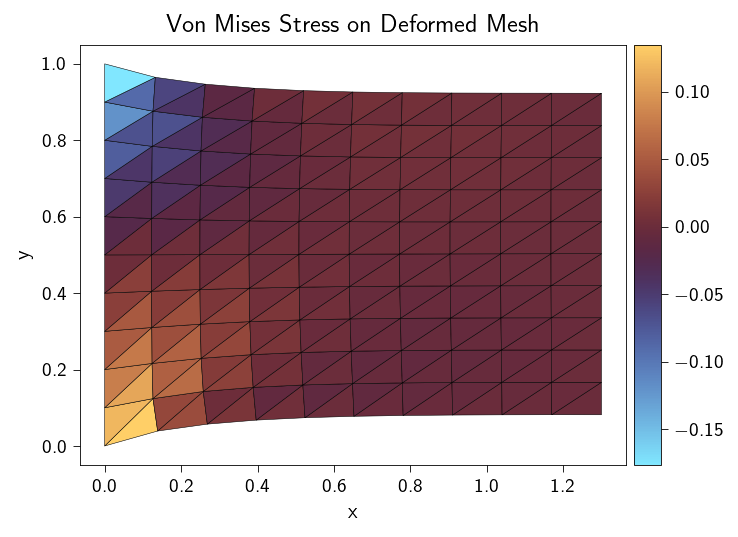

In [35]:
plot_displacement_and_stress(u_solution, mesh, stresses[:, 0, 1].flatten())